In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

In [ ]:
from modules.dqn.network import QNetworkConv
from world import CatchEnv

n_actions = 3
n_episodes = 1000
batch_size = 512

CATCH_ENV_NUM_STATES = 4
CATCH_ENV_WORLD_SIZE = (84, 84)
CATCH_ENV_POSSIBLE_ACTIONS = [0, 1, 2]

spatial_size = CATCH_ENV_WORLD_SIZE

dqn = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES, 
    spatial_size=spatial_size, 
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)
dqn_target = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES,
    spatial_size=spatial_size,
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)

In [ ]:
env = CatchEnv()
env.reset_random()
next_state, reward, done = env.step(action=1)
next_state.shape, reward, done

In [ ]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(spatial_size),
    lambda x: x.unsqueeze(0),
    lambda x: x.type(torch.float32),
])

transforms(next_state).shape

In [ ]:
optimizer = optim.Adam(dqn.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

num_episodes = 1000
epsilon = 0.8
gamma = 0.9


In [ ]:
import random
from collections import deque

# Define a replay buffer class to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done_flags = zip(*batch)
        return states, actions, rewards, next_states, done_flags

# Initialize the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

# Define the main training loop
for episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset_random()
    state = transforms(state)
    done = False
    
    while not done:
        # Choose an action using an epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
        else:
            q_values = dqn(state.to(device))
            action = q_values.argmax().item()
        
        # Take the action and observe the next state and reward
        next_state, reward, done = env.step(action)
        next_state = transforms(next_state)
        
        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer.buffer) > batch_size:
            states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
            # (batch, 4, 84, 84)
            # [(1, 4, 84, 84), ... ] -> (batch, 4, 84, 84)
            
            states = torch.cat(states).to(device)
            actions = torch.Tensor(actions).type(dtype=torch.int64).to(device)
            rewards = torch.Tensor(rewards).to(device)
            next_states = torch.cat(next_states).to(device)
            done_flags = torch.Tensor(done_flags).to(device)

            # Compute the target Q-values using the DDQN algorithm
            q_values = dqn(states)
            max_actions = q_values.argmax(dim=-1)
            
            with torch.no_grad():
                q_values_target = dqn_target(next_states)
            q_values_target = q_values_target.gather(1, max_actions.unsqueeze(-1)).squeeze(-1)
            q_values_target = rewards + gamma * q_values_target * (1 - done_flags)
            
            # Compute the current Q-values and the loss
            current_q_values = q_values.gather(1, torch.Tensor(actions).unsqueeze(-1)).squeeze(-1)
            loss = criterion(current_q_values, q_values_target.detach())
            
            # Update the DQN network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the target network
            dqn_target.load_state_dict(dqn.state_dict())
        
        # Update the state
        state = next_state

In [9]:
torch.save(dqn.state_dict(), "models/dqn_conv.pth")

action: 0, reward: 1, done: True


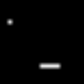

In [126]:
# evluation
env = CatchEnv()
state = env.reset_random()
state = transforms(state)
video = []

while True:
    q_values = dqn(state.to(device))
    action = q_values.argmax().item()
    next_state, reward, done = env.step(action)
    next_state = transforms(next_state)
    state = next_state
    video.append(next_state.squeeze(0))
    if done:
        break

frames = []
video = torch.stack(video)
# shape (k iterations, 4 frames, 84, 84)
# put side to side resulting in (4 * k, 84, 84) without changing the order
video = video.permute(1, 0, 2, 3).reshape(4 * len(video), 84, 84)

# video is of shape (time, 84, 84)
# make a gif and display it
import imageio
from IPython.display import Image

imageio.mimsave("dqn_conv.gif", 255 * video.cpu().numpy())
Image(filename="dqn_conv.gif", format='png')